In [26]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train = pd.read_csv("../data/train_test/train.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1911 entries, 0 to 1910
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  1911 non-null   object 
 1   type      1911 non-null   object 
 2   year      1911 non-null   int64  
 3   month     1911 non-null   object 
 4   value     1911 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 74.8+ KB


In [5]:
train.year.value_counts()

2020    91
2009    91
2001    91
2002    91
2003    91
2004    91
2005    91
2006    91
2007    91
2008    91
2010    91
2019    91
2011    91
2012    91
2013    91
2014    91
2015    91
2016    91
2017    91
2018    91
2000    91
Name: year, dtype: int64

# EDA

To avoid *overfitting* with our insights, we use only a half of the training set for exploration.

In [6]:
eda_df = train[train.year <= 2010]

In [7]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 130 to 1910
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  1001 non-null   object 
 1   type      1001 non-null   object 
 2   year      1001 non-null   int64  
 3   month     1001 non-null   object 
 4   value     1001 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 46.9+ KB


In [8]:
eda_df['category'].value_counts()

Verkehrsunfälle    429
Alkoholunfälle     286
Fluchtunfälle      286
Name: category, dtype: int64

In [9]:
eda_df['type'].value_counts()

insgesamt                 429
Verletzte und Getötete    429
mit Personenschäden       143
Name: type, dtype: int64

In [10]:
eda_df['year'].value_counts()

2010    91
2009    91
2008    91
2007    91
2006    91
2005    91
2004    91
2003    91
2002    91
2001    91
2000    91
Name: year, dtype: int64

In [11]:
eda_df['month'].value_counts()

Summe     77
200412     7
200202     7
200201     7
200312     7
          ..
200703     7
200702     7
200701     7
200812     7
200012     7
Name: month, Length: 133, dtype: int64

In [12]:
# month == 'Summe' contains values aggregated yearly
# these rows need to be dropped before training
eda_df[eda_df['month'] == 'Summe'].groupby('year').sum() == eda_df[eda_df['month'] != 'Summe'].groupby('year').sum()

,value
year,
2000,True
2001,True
2002,True
2003,True
2004,True
2005,True
2006,True
2007,True
2008,True


In [13]:
# month values are of incorrect format
# use regex to extract month number
eda_df['month'].str.extract(r'\d\d\d\d(\d\d)')

,0
130,NaN
131,01
132,02
133,03
134,04
...,...
1906,08
1907,09
1908,10
1909,11


In [14]:
eda_df['value'].describe()

count     1001.000000
mean      1375.538462
std       4394.788956
min          5.000000
25%         46.000000
50%        396.000000
75%        837.000000
max      45713.000000
Name: value, dtype: float64

In [15]:
subset_eda_df = eda_df[(eda_df['month'] != 'Summe')\
                       & (eda_df['category'] == 'Alkoholunfälle')\
                       & (eda_df['type'] == 'insgesamt')
                      ]
subset_eda_df.describe()

,year,value
count,132.000000,132.000000
mean,2005.000000,53.386364
std,3.174324,18.303067
min,2000.000000,14.000000
25%,2002.000000,40.000000
50%,2005.000000,51.000000
75%,2008.000000,65.000000
max,2010.000000,107.000000


In [23]:
subset_eda_df['month'] = subset_eda_df['month'].str.extract(r'\d\d\d\d(\d\d)')
subset_eda_df['date'] = pd.to_datetime(subset_eda_df['year'].astype(str) + '-' + subset_eda_df['month'])

/tmp/ipykernel_206219/2506050632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_eda_df['month'] = subset_eda_df['month'].str.extract(r'\d\d\d\d(\d\d)')
/tmp/ipykernel_206219/2506050632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_eda_df['date'] = pd.to_datetime(subset_eda_df['year'].astype(str) + '-' + subset_eda_df['month'])


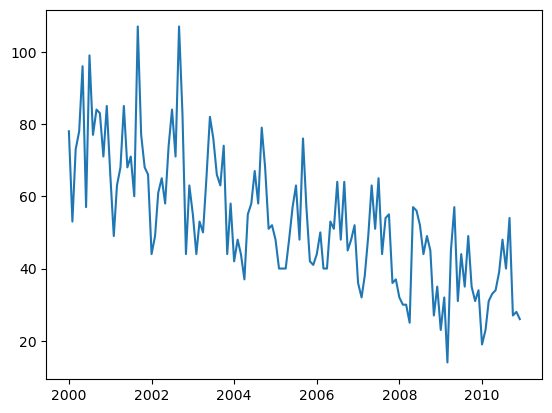

In [28]:
grouped = subset_eda_df.groupby('date').sum()
plt.plot(grouped.index, grouped.value)

16:00:12 - cmdstanpy - INFO - Chain [1] start processing
16:00:13 - cmdstanpy - INFO - Chain [1] done processing


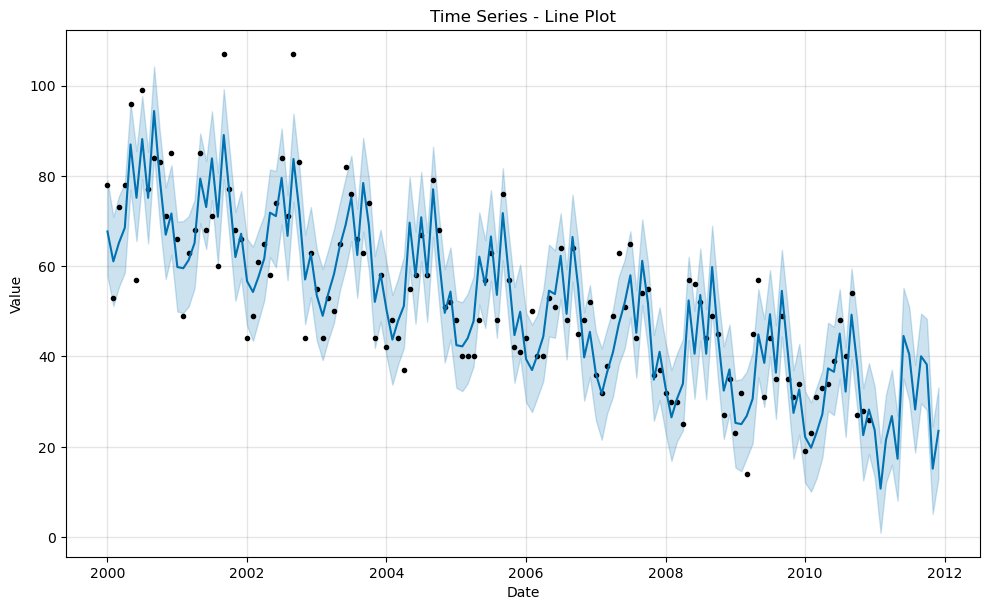

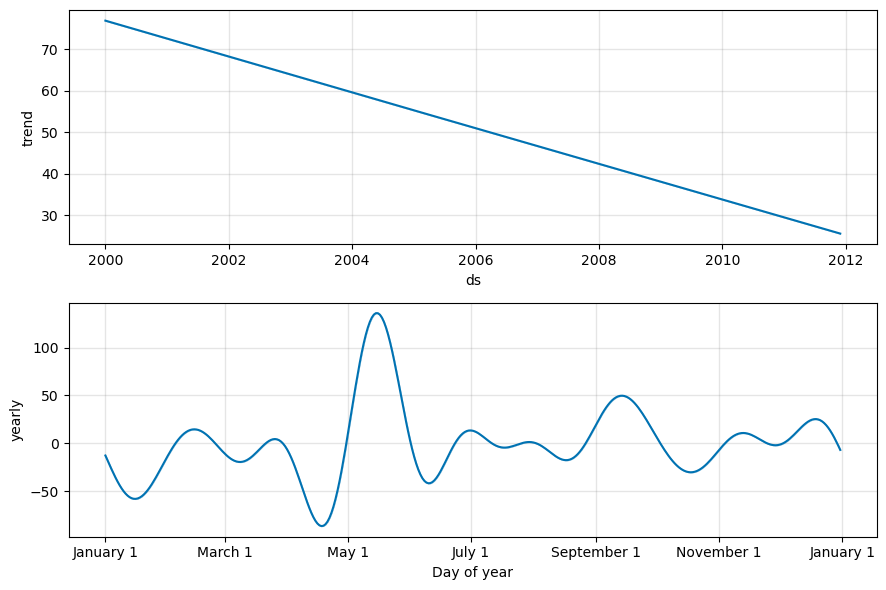

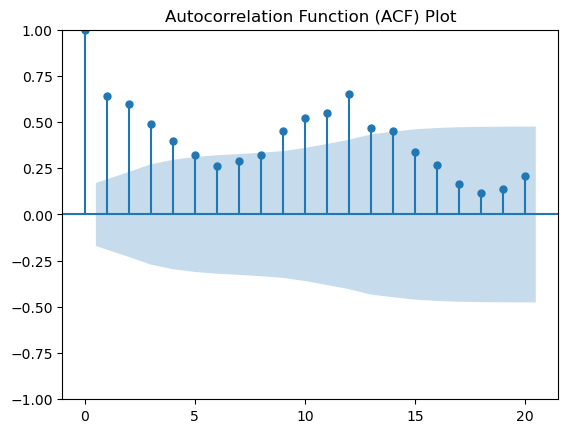

/home/wrabbit/.conda/envs/simpleml/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


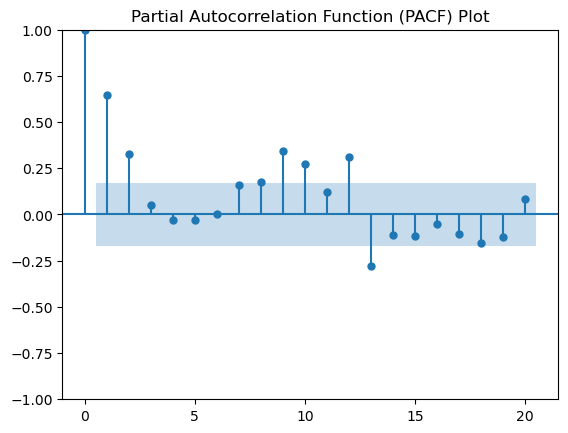

In [33]:
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Convert the 'ds' column to datetime if it's not already in the correct format
data = pd.DataFrame()
data['ds'] = subset_eda_df['date']
data['y'] = subset_eda_df['value']

# Sort the data by date in ascending order
data = data.sort_values('ds')

# Initialize the Prophet model
model = Prophet()

# Fit the model to the data
model.fit(data)

# Create a future DataFrame for prediction
future = model.make_future_dataframe(periods=12, freq='M')

# Generate the predictions
forecast = model.predict(future)

# Line Plot
model.plot(forecast, xlabel='Date', ylabel='Value')
plt.title('Time Series - Line Plot')
plt.show()

# Seasonal Decomposition Plot
model.plot_components(forecast)
plt.show()

# ACF Plot
plot_acf(data['y'], lags=20)
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

# PACF Plot
plot_pacf(data['y'], lags=20)
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.show()
